# Protein Classification Challenge – First Challenge

**Name:** AJ Book  
**Course:** EN.605.656.8VL – Computational Drug Discovery and Development  
**Due Date:** 03/27/2025  

---

This notebook implements comprehensive preprocessing and feature engineering for the **Protein Classification Challenge** using the `metadata_org.csv` dataset. It includes:

- Replacement of unknown amino acids  
- Sequence-level feature extraction  
- Amino acid and dipeptide frequency analysis  
- Reduced amino acid alphabet transformations  
- N-gram profiling from grouped residue classes  
- Physicochemical property extraction using BioPython

Each section includes both code and explanatory answers to the associated challenge questions. The final output is a unified, feature-rich dataset (`metadata_org_w_features.csv`) suitable for use in downstream machine learning pipelines for protein functional classification.


In [1]:
# Standard Library
import re
import itertools
from collections import Counter

# Data Handling
import numpy as np
import pandas as pd
import seaborn as sns

# Bioinformatics
from Bio.SeqUtils.ProtParam import ProteinAnalysis

# Machine Learning and Preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report
)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set default plot style
sns.set(style="whitegrid")


/home/secondbook5/micromamba/envs/comp_drug_disc/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
# Load the raw dataset
data = pd.read_csv("metadata_org.csv")

# Display the first few records to confirm successful load
data.head()


,Entry,Sequence,Selected_PDB,ProteinClass
0,P21611,MGKAAAVVLVTLVALLGLAQADLTPKVQVYSRFPASAGTKNVLNCF...,3p73,MHC
1,Q66GT5,MAASAWLEAGLARVLFYPTLLYTVFRGRVRGPAHRDWYHRIDHTVL...,3rgo,Phosphatase
2,Q9Y006,MNLTIKEEDFTNTFMKNEESFNTFRVTKVKRWNAKRLFKILFVTVF...,3qvc,Protease
3,P05622,MGLPGVIPALVLRGQLLLSVLWLLGPQTSRGLVITPPGPEFVLNIS...,1aya,RTK
4,P06343,MALQIPSLLLLAAVVVLTVLSSPGTEGGNSERHFVHQFQPFCYFTN...,1d9k,MHC


In [3]:
# Display basic structure and memory usage
data.info()

# Check for duplicates in key columns
duplicates = data.duplicated(subset=["Entry", "Sequence", "Selected_PDB"]).sum()
print(f"\nDuplicate rows (Entry, Sequence, Selected_PDB): {duplicates}")

# Display missing value counts
print("\nMissing values per column:")
print(data.isnull().sum())

# Count unique protein classes
unique_classes = data["ProteinClass"].nunique()
print(f"\nNumber of unique protein classes: {unique_classes}")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 681 entries, 0 to 680
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Entry         681 non-null    object
 1   Sequence      681 non-null    object
 2   Selected_PDB  681 non-null    object
 3   ProteinClass  681 non-null    object
dtypes: object(4)
memory usage: 21.4+ KB

Duplicate rows (Entry, Sequence, Selected_PDB): 0

Missing values per column:
Entry           0
Sequence        0
Selected_PDB    0
ProteinClass    0
dtype: int64

Number of unique protein classes: 10


In [4]:
# Generate descriptive statistics for numeric columns
data.describe()


,Entry,Sequence,Selected_PDB,ProteinClass
count,681,681,681,681
unique,681,679,673,10
top,P21611,MNLTIKEEDFTNTFMKNEESFNTFRVTKVKRWNAKRLFKILFVTVF...,5h8f,GPCR
freq,1,2,2,144


In [5]:
# Unique value counts for object columns
print("Unique values in ProteinClass:")
print(data['ProteinClass'].value_counts())

print("\nUnique values in Selected_PDB:")
print(data['Selected_PDB'].nunique())


Unique values in ProteinClass:
ProteinClass
GPCR           144
Channel        142
Protease        79
ATPase          66
RTK             64
Phosphatase     56
Ser:Thr         49
MHC             45
Integrin        21
Aquaporin       15
Name: count, dtype: int64

Unique values in Selected_PDB:
673


/tmp/ipykernel_1906427/2550219587.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x='ProteinClass',


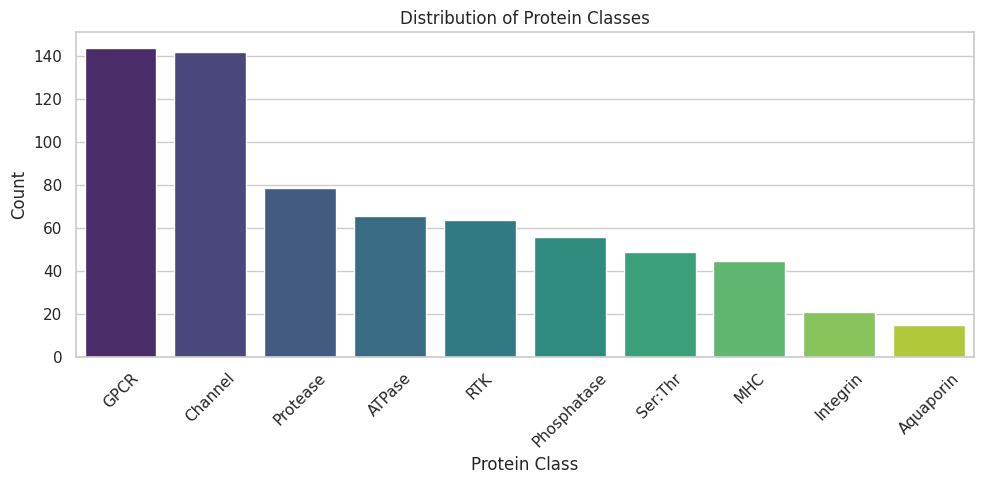

In [6]:
# Protein class distribution
plt.figure(figsize=(10, 5))
sns.countplot(data=data, x='ProteinClass',
              order=data['ProteinClass'].value_counts().index, palette="viridis")
plt.title("Distribution of Protein Classes")
plt.xlabel("Protein Class")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Protein Class Distribution

To understand the balance and composition of the dataset, the number of sequences in each of the ten protein classes was visualized. As shown in the plot above, the dataset is imbalanced, with **GPCRs** and **Channel proteins** dominating the distribution, each representing over 140 samples. In contrast, classes such as **Integrin** and **Aquaporin** are underrepresented. This class imbalance should be taken into account during model training and evaluation, as it may bias classification results if not properly addressed with techniques such as stratified sampling or class weighting.


# Replace unknown amino acids with Alanine

### Question 1: Unknown Amino Acids

**• Why is it good practice to replace unknown amino acids?**  
Replacing unknown amino acids is considered good practice because most bioinformatics tools, including those for feature extraction and modeling, are designed to interpret only the standard 20 amino acids. Unknown or ambiguous characters such as 'X' or '*' introduce uncertainty and can cause these tools to fail or produce misleading results. By substituting them with defined residues, the integrity of the data is preserved, ensuring compatibility with downstream analyses and reducing the likelihood of computational errors or skewed feature distributions.

**• Why does this notebook use alanine to replace unknown amino acids?**  
Alanine is used in this notebook as a default replacement for unknown amino acids because it is one of the most structurally neutral and frequently occurring amino acids. It does not introduce significant charge, polarity, or steric hindrance, making it a reasonable conservative substitute in the absence of contextual information. This choice minimizes the potential bias that might arise from inserting a more chemically unique or functionally critical amino acid.

**• What other amino acids could substitute unknown amino acids?**  
In place of alanine, other amino acids could be used depending on the specific application and assumptions. Glycine, for example, is the smallest amino acid and is often considered for minimal steric impact. Serine, with its mild polarity, may also serve as a neutral placeholder. Alternatively, data-driven approaches could be employed to replace unknown residues with the most frequent residue at that position in homologous sequences or based on similarity scores from substitution matrices like BLOSUM. These strategies may yield more biologically informed replacements, particularly in high-confidence alignment contexts.


In [7]:
# Replace unknown amino acids (e.g., 'X') with a default placeholder ('A')

def replace_unknown_amino_acids(sequence, replacement='A'):
    """
    Replaces all occurrences of 'X' in a protein sequence with the specified amino acid.

    Args:
        sequence (str): Original amino acid sequence.
        replacement (str): Amino acid used to replace unknowns (default is 'A').

    Returns:
        str: Cleaned sequence.
    """
    return sequence.replace('X', replacement)

# Apply the replacement function to the sequence column
data['CleanSequence'] = data['Sequence'].apply(replace_unknown_amino_acids)

# Preview the result
data[['Sequence', 'CleanSequence']].head()


,Sequence,CleanSequence
0,MGKAAAVVLVTLVALLGLAQADLTPKVQVYSRFPASAGTKNVLNCF...,MGKAAAVVLVTLVALLGLAQADLTPKVQVYSRFPASAGTKNVLNCF...
1,MAASAWLEAGLARVLFYPTLLYTVFRGRVRGPAHRDWYHRIDHTVL...,MAASAWLEAGLARVLFYPTLLYTVFRGRVRGPAHRDWYHRIDHTVL...
2,MNLTIKEEDFTNTFMKNEESFNTFRVTKVKRWNAKRLFKILFVTVF...,MNLTIKEEDFTNTFMKNEESFNTFRVTKVKRWNAKRLFKILFVTVF...
3,MGLPGVIPALVLRGQLLLSVLWLLGPQTSRGLVITPPGPEFVLNIS...,MGLPGVIPALVLRGQLLLSVLWLLGPQTSRGLVITPPGPEFVLNIS...
4,MALQIPSLLLLAAVVVLTVLSSPGTEGGNSERHFVHQFQPFCYFTN...,MALQIPSLLLLAAVVVLTVLSSPGTEGGNSERHFVHQFQPFCYFTN...


In [8]:
# Initialize base DataFrames to track identifiers and class labels

# Primary identifier, label, and cleaned sequence
df = data[['Entry', 'ProteinClass', 'Selected_PDB', 'CleanSequence']].copy()



# Master feature table (will accumulate features)
df_all = data[['Entry', 'ProteinClass']].copy()

# Preview initial structure
df.head()

,Entry,ProteinClass,Selected_PDB,CleanSequence
0,P21611,MHC,3p73,MGKAAAVVLVTLVALLGLAQADLTPKVQVYSRFPASAGTKNVLNCF...
1,Q66GT5,Phosphatase,3rgo,MAASAWLEAGLARVLFYPTLLYTVFRGRVRGPAHRDWYHRIDHTVL...
2,Q9Y006,Protease,3qvc,MNLTIKEEDFTNTFMKNEESFNTFRVTKVKRWNAKRLFKILFVTVF...
3,P05622,RTK,1aya,MGLPGVIPALVLRGQLLLSVLWLLGPQTSRGLVITPPGPEFVLNIS...
4,P06343,MHC,1d9k,MALQIPSLLLLAAVVVLTVLSSPGTEGGNSERHFVHQFQPFCYFTN...


# Add Sequence Length

### Question 2: Add Sequence Length

**• Why calculate sequence length?**  
Sequence length was calculated to provide a foundational structural descriptor for each protein. This feature can correlate with the functional complexity and domain architecture of a protein, which may be informative for classification. Including sequence length allows downstream models to learn associations between size and function, and can serve as a minimal yet informative feature in machine learning pipelines.

**• How to verify if df_seq contains the necessary data?**  
The DataFrame `df_seq` was constructed directly from the `'CleanSequence'` column in the main dataset. A new column, `'SequenceLength'`, was computed by applying a custom `sequence_length()` function to each sequence. The `.head()` method was then used to preview the top rows of `df_seq`, confirming the successful addition of the new feature and validating that each row now contained both the cleaned sequence and its corresponding length.

**• How does sequence length influence protein stability and function?**  
Sequence length influences both the structural and functional properties of proteins. Shorter sequences may encode peptides or single-domain proteins that fold quickly and exhibit limited functionality, whereas longer sequences tend to fold into more complex three-dimensional structures with multi-domain organization, enabling diverse interactions and functional specificity. Additionally, longer sequences may be more susceptible to instability or degradation unless properly folded, often requiring assistance from chaperones or other cellular machinery. As such, length serves as a meaningful proxy for potential biological behavior.

In [9]:
# Create a DataFrame for sequence-level features
df_seq = data[['CleanSequence']].copy()

# Define a function to calculate sequence length
def sequence_length(sequence):
    """
    Computes the number of amino acids in a given sequence.

    Args:
        sequence (str): A protein sequence (cleaned).

    Returns:
        int: Length of the sequence.
    """
    return len(sequence)

# Compute sequence length and add to both tracking tables
df_seq['SequenceLength'] = df_seq['CleanSequence'].apply(sequence_length)
df_all['SequenceLength'] = df_seq['SequenceLength']

# Preview the sequence-level features
df_seq.head()


,CleanSequence,SequenceLength
0,MGKAAAVVLVTLVALLGLAQADLTPKVQVYSRFPASAGTKNVLNCF...,119
1,MAASAWLEAGLARVLFYPTLLYTVFRGRVRGPAHRDWYHRIDHTVL...,193
2,MNLTIKEEDFTNTFMKNEESFNTFRVTKVKRWNAKRLFKILFVTVF...,451
3,MGLPGVIPALVLRGQLLLSVLWLLGPQTSRGLVITPPGPEFVLNIS...,1098
4,MALQIPSLLLLAAVVVLTVLSSPGTEGGNSERHFVHQFQPFCYFTN...,263


# Amino Acid Frequencies

In [10]:
# Define the list of 20 standard amino acids
amino_acids = list('ACDEFGHIKLMNPQRSTVWY')

# Function to compute normalized amino acid composition using the updated attribute
def calculate_aac(sequence):
    """
    Computes the fraction of each amino acid in a sequence using BioPython's ProteinAnalysis.
    
    Args:
        sequence (str): Cleaned amino acid sequence.
    
    Returns:
        list[float]: Amino acid frequencies in the order of standard amino acids.
    """
    analysis = ProteinAnalysis(sequence)
    composition = analysis.amino_acids_percent  # Updated from deprecated method
    return [composition.get(aa, 0.0) for aa in amino_acids]

# Apply the function and structure the AAC DataFrame
df_aac = data['CleanSequence'].apply(calculate_aac)
aac_df = pd.DataFrame(df_aac.tolist(), columns=amino_acids)

# Store AAC features
df_freq = aac_df.copy()
df_all = pd.concat([df_all, aac_df], axis=1)

# Preview
df_freq.head()


,A,C,D,E,F,G,H,I,K,L,M,N,P,Q,R,S,T,V,W,Y
0,10.924370,1.680672,5.882353,4.201681,5.882353,5.882353,2.521008,1.680672,6.722689,8.403361,3.361345,2.521008,6.722689,4.201681,1.680672,6.722689,6.722689,9.243697,1.680672,3.361345
1,10.880829,1.554404,2.072539,6.735751,2.590674,5.181347,4.145078,4.663212,5.699482,10.880829,2.590674,3.626943,3.108808,3.108808,8.290155,4.663212,6.217617,8.290155,2.072539,3.626943
2,2.882483,0.886918,4.878049,6.873614,7.982262,5.321508,1.552106,6.208426,10.421286,8.869180,1.552106,7.317073,3.547672,1.552106,1.773836,7.982262,6.873614,7.760532,0.886918,4.878049
3,4.371585,1.730419,5.646630,6.921676,3.005464,6.102004,2.185792,5.009107,3.642987,10.473588,2.732240,3.642987,6.557377,3.916211,4.826958,9.198543,6.102004,8.561020,1.275046,4.098361
4,4.182510,1.901141,2.281369,7.604563,3.802281,7.224335,3.041825,4.182510,2.661597,10.266160,1.520913,3.422053,5.323194,4.562738,9.125475,7.224335,7.224335,9.125475,1.520913,3.802281


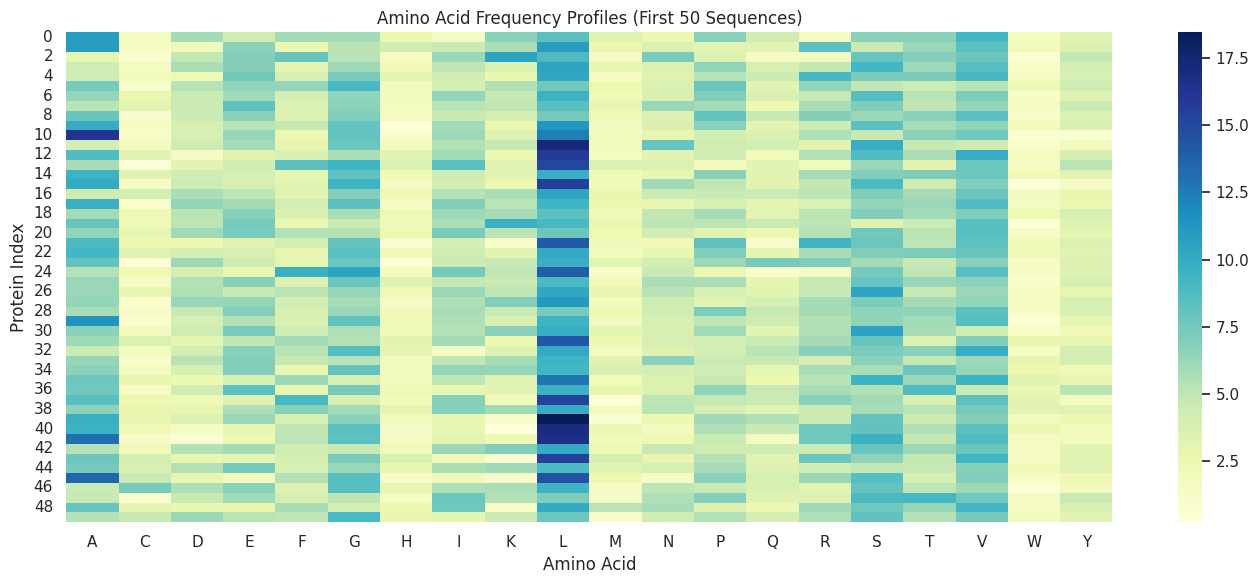

In [11]:
# Heatmap of amino acid frequencies across sequences
plt.figure(figsize=(14, 6))
sns.heatmap(df_freq.iloc[:50], cmap="YlGnBu", cbar=True)
plt.title("Amino Acid Frequency Profiles (First 50 Sequences)")
plt.xlabel("Amino Acid")
plt.ylabel("Protein Index")
plt.tight_layout()
plt.show()

# All possible dipeptide frequencies

### Question 3: All Possible Dipeptide Frequencies

**• What is a dipeptide?**  
A dipeptide is a simple molecule formed by the covalent linkage of two amino acids through a peptide bond. It represents the most basic unit of sequence motifs beyond single-residue composition, and can capture local sequence ordering. In the context of protein analysis, dipeptides serve as interpretable and computationally efficient descriptors of short-range residue relationships.

**• What type of bond is formed between two amino acids in a dipeptide?**  
The bond formed between two amino acids in a dipeptide is a peptide bond, also known as an amide bond. This bond results from a condensation reaction between the carboxyl group of one amino acid and the amino group of another, releasing a molecule of water. The peptide bond is a defining feature of protein primary structure and forms the backbone of all polypeptides.

**• Why focus on dipeptides instead of tripeptides or polypeptides?**  
Dipeptides were selected in this notebook due to their balance between biological informativeness and computational efficiency. While tripeptides and longer motifs provide greater context, they result in exponentially larger feature spaces, which can lead to sparsity and increased model complexity—especially with modest-sized datasets. In contrast, dipeptides cover all 400 possible combinations from the 20 standard amino acids and provide a manageable feature set that captures pairwise residue preferences, which are often sufficient for detecting structural or functional signals.

**• How might dipeptide frequency contribute to machine learning-based protein classification?**  
Dipeptide frequencies encode short-range sequential dependencies that reflect both structural tendencies and evolutionary constraints. These pairwise residue transitions can reveal conserved biochemical patterns or preferences in specific protein classes, such as the enrichment of certain motifs in membrane proteins or enzymes. By normalizing the frequencies across all sequences, the resulting 400-dimensional vector serves as a good foundation of splittable input for machine learning models, enabling them to learn class-distinguishing patterns based on localized sequence structure.


In [12]:
# Define list of standard amino acids and all possible dipeptides
amino_acids = list('ACDEFGHIKLMNPQRSTVWY')
dipeptides = [''.join(dp) for dp in itertools.product(amino_acids, repeat=2)]

# Function to calculate dipeptide composition
def calculate_dipeptide_comp(sequence):
    """
    Computes normalized frequencies of all possible dipeptides in a protein sequence.

    Args:
        sequence (str): Amino acid sequence.

    Returns:
        list[float]: Normalized dipeptide frequencies in the order of all 400 dipeptides.
    """
    total_dipeptides = len(sequence) - 1
    if total_dipeptides <= 0:
        return [0.0] * len(dipeptides)

    # Generate observed dipeptides
    observed = [sequence[i:i+2] for i in range(total_dipeptides)]

    # Count frequencies
    counts = Counter(observed)

    # Normalize and preserve order
    return [counts.get(dp, 0) / total_dipeptides for dp in dipeptides]

# Apply function to all sequences
df_dipep = data['CleanSequence'].apply(calculate_dipeptide_comp)

# Convert results to DataFrame
dipeptide_df = pd.DataFrame(df_dipep.tolist(), columns=dipeptides)

# Track separately and append to master feature set
df_dipep = dipeptide_df.copy()
df_all = pd.concat([df_all, dipeptide_df], axis=1)

# Preview
df_dipep.head()

,AA,AC,AD,AE,AF,AG,AH,AI,AK,AL,...,YM,YN,YP,YQ,YR,YS,YT,YV,YW,YY
0,0.025424,0.008475,0.016949,0.000000,0.000000,0.016949,0.000000,0.000000,0.000000,0.008475,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.016949,0.000000,0.000000,0.000000,0.000000
1,0.015625,0.000000,0.000000,0.000000,0.000000,0.015625,0.005208,0.010417,0.010417,0.015625,...,0.000000,0.000000,0.005208,0.005208,0.000000,0.000000,0.005208,0.005208,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.004444,0.000000,0.000000,0.006667,0.004444,...,0.000000,0.000000,0.000000,0.000000,0.002222,0.006667,0.002222,0.002222,0.000000,0.002222
3,0.001823,0.000912,0.001823,0.005469,0.001823,0.001823,0.001823,0.003646,0.000000,0.003646,...,0.001823,0.001823,0.002735,0.001823,0.001823,0.001823,0.004558,0.005469,0.000000,0.001823
4,0.003817,0.000000,0.000000,0.007634,0.000000,0.003817,0.000000,0.000000,0.003817,0.007634,...,0.000000,0.003817,0.003817,0.000000,0.003817,0.000000,0.003817,0.003817,0.003817,0.000000


# Reduced Amino Acid Alphabet

In [13]:
# Define amino acid groupings based on shared physicochemical properties
groupings = {
    'Aliphatic': 'GAVLIPM',
    'Aromatic': 'FYW',
    'Polar_Uncharged': 'STCQN',
    'Positive_Charged': 'HKR',
    'Negative_Charged': 'DE',
}

# Function to reduce amino acid sequence to representative group letters
def reduce_alphabet(sequence):
    """
    Maps each amino acid in a sequence to a representative amino acid
    from its biochemical group. Unmatched characters are marked as 'X'.

    Args:
        sequence (str): Cleaned amino acid sequence.

    Returns:
        str: Reduced amino acid sequence using group representatives.
    """
    reduced_sequence = []
    for aa in sequence:
        found = False
        for group, members in groupings.items():
            if aa in members:
                reduced_sequence.append(members[0])  # Use first AA as representative
                found = True
                break
        if not found:
            reduced_sequence.append('X')  # Unclassified residues
    return ''.join(reduced_sequence)

# Apply the reduction to all sequences
data['RedSequence'] = data['CleanSequence'].apply(reduce_alphabet)

# Define group representative letters to be used in later steps
group_representatives = [members[0] for members in groupings.values()]


# Reduced Amino Acid Alphabet Frequencies

### Question 4: Reduced Amino Acid Alphabet Frequencies

**• Why is reducing the amino acid alphabet beneficial in bioinformatics?**  
Reducing the amino acid alphabet simplifies sequence representations by clustering residues with similar physicochemical properties into broader functional groups. This abstraction reduces dimensionality and allows patterns to emerge more clearly in datasets where full 20-residue specificity might be unnecessary or even detrimental due to sparsity. It enhances interpretability and improves the robustness of downstream analyses such as clustering, classification, and sequence comparison, particularly when working with small or noisy datasets.

**• What criteria are used to group amino acids? (e.g., hydrophobicity, charge, size)**  
In this notebook, amino acids were grouped based on shared biochemical characteristics: hydrophobicity, aromaticity, polarity, and net charge. Specifically, the five groups used were: aliphatic (G, A, V, L, I, P, M), aromatic (F, Y, W), polar uncharged (S, T, C, Q, N), positively charged (H, K, R), and negatively charged (D, E). Each group was represented by the first amino acid in its set, and any residue not matching these criteria was labeled as ‘X’. This grouping reflects core properties that influence protein folding, solubility, and interaction behavior.

**• Impact of reduced alphabet on sequence alignment and phylogenetic analysis?**  
Reducing the amino acid alphabet can significantly improve the sensitivity and computational efficiency of sequence alignment algorithms. By focusing on broader functional categories rather than individual residues, alignments become more tolerant to conservative substitutions, which often reflect evolutionary conservation at the biochemical level. In phylogenetic analysis, reduced alphabets help highlight deeper evolutionary relationships by smoothing over noisy residue-level mutations. However, this comes at the cost of losing fine-grained sequence detail, which may be necessary in certain structural or active-site analyses.


In [14]:
from collections import Counter

# Function to compute normalized frequency of each amino acid group
def calculate_group_freq(sequence):
    """
    Calculates the normalized frequency of each reduced amino acid group in a sequence.

    Args:
        sequence (str): Reduced sequence using group representatives.

    Returns:
        list[float]: Normalized frequencies of group representatives in the specified order.
    """
    total = len(sequence)
    if total == 0:
        return [0.0] * len(group_representatives)
    
    counts = Counter(sequence)
    return [counts.get(grp, 0) / total for grp in group_representatives]

# Apply group frequency calculation to each reduced sequence
group_freq = data['RedSequence'].apply(calculate_group_freq)

# Create DataFrame for group frequencies
group_freq_df = pd.DataFrame(group_freq.tolist(), columns=group_representatives)

# Track separately and append to master feature table
df_red_freq = group_freq_df.copy()
df_all = pd.concat([df_all, group_freq_df], axis=1)

# Preview result
df_red_freq.head()


,G,F,S,H,D
0,0.462185,0.109244,0.218487,0.109244,0.100840
1,0.455959,0.082902,0.191710,0.181347,0.088083
2,0.361419,0.137472,0.246120,0.137472,0.117517
3,0.438069,0.083789,0.245902,0.106557,0.125683
4,0.418251,0.091255,0.243346,0.148289,0.098859


# N-Gram Profiles of Reduced Amino Acid Alphabet

### Question 5: N-Gram Profiles of Reduced Amino Acid Alphabet

**• What are N-grams in the context of protein sequences?**  
N-grams in protein sequences refer to ordered, overlapping substrings of length *N* that are extracted from a given amino acid sequence. These represent local residue patterns that capture sequential structure, analogous to k-mers in genomics. For instance, given a reduced amino acid sequence such as `GAGFG`, the 2-grams would be `GA`, `AG`, `GF`, and `FG`. In this notebook, N-grams were generated from reduced sequences using group representatives (e.g., G for aliphatic, F for aromatic), preserving information about biochemical group transitions rather than individual residues.

**• Why are N-grams helpful in studying protein sequences?**  
N-grams help capture short-range dependencies and structural motifs that are often biologically meaningful. They encode the order in which amino acid groups appear, which can reflect key structural elements such as α-helices, β-strands, or disordered loops. This local context is critical for function and often conserved across homologous sequences. In the notebook, frequencies of all possible 2-grams and 3-grams from the reduced alphabet were computed for each sequence, allowing machine learning models to learn from these patterns without requiring full sequence alignment or positional encoding.

**• How does increasing the N-value affect N-gram complexity?**  
Increasing the value of *N* exponentially increases the number of possible combinations, which directly impacts the feature space. For the 5-character reduced alphabet used in this notebook, the number of features is:
- 5² = 25 for 2-grams  
- 5³ = 125 for 3-grams  

As *N* increases, the resulting N-gram space becomes more expressive but also more sparse, especially for shorter sequences. This tradeoff must be managed carefully—larger *N* values can overfit the data unless sufficiently large and diverse training sets are used. In the implementation, both 2-grams and 3-grams were included to strike a balance between motif resolution and dimensionality.

**• Why use RAAA-based N-grams instead of the full 20 amino acid set?**  
RAAA (Reduced Amino Acid Alphabet)-based N-grams were used in this notebook to reduce the dimensionality and improve biological generalization. With the full 20-residue set, 2-gram frequencies would yield 400 features and 3-grams would generate 8,000—many of which may be rare or redundant. By abstracting amino acids into five chemically meaningful groups (e.g., aliphatic, aromatic, polar uncharged, positive, negative), the model captures high-level biochemical transitions rather than memorizing residue-level variations. This is particularly useful when working with modest datasets, as it minimizes overfitting and emphasizes conserved physicochemical behavior over exact sequence identity.

**• Applications of N-gram profiles in protein classification into functional families?**  
N-gram profiles serve as sequence-derived embeddings that reflect conserved short-range biochemical patterns. These can be directly used as input features for machine learning models to classify proteins into functional families, such as kinases, GPCRs, or enzymes, based on the presence or absence of specific residue motifs. In the current pipeline, the 2-gram and 3-gram frequencies of the reduced sequences were appended to the master feature table, enabling downstream classifiers to identify class-discriminating patterns. These profiles can also complement structural features and be used in hybrid models for function prediction, structural class inference, or fold recognition.


In [15]:
# Generate all possible n-grams from group representatives
def generate_ngrams(group_representatives, n):
    """
    Generates all possible n-grams from a list of characters.

    Args:
        group_representatives (list[str]): List of group representative characters.
        n (int): The desired n-gram size.

    Returns:
        list[str]: All possible n-gram combinations.
    """
    return [''.join(ng) for ng in itertools.product(group_representatives, repeat=n)]

# Calculate normalized frequency of n-grams in a given sequence
def calculate_ngram_freq(sequence, n, ngrams):
    """
    Computes normalized frequency of each n-gram in the provided sequence.

    Args:
        sequence (str): Reduced amino acid sequence.
        n (int): Size of the n-gram.
        ngrams (list[str]): All valid n-gram patterns.

    Returns:
        list[float]: Normalized frequencies in the same order as `ngrams`.
    """
    total = len(sequence) - n + 1
    if total <= 0:
        return [0.0] * len(ngrams)

    # Extract observed n-grams
    observed = [sequence[i:i+n] for i in range(total)]
    counts = Counter(observed)

    return [counts.get(ng, 0) / total for ng in ngrams]

# Initialize empty DataFrame for storing n-gram features
df_red_ngram = pd.DataFrame()

# Loop over desired n-gram sizes (2-gram and 3-gram)
for n in [2, 3]:
    ngrams = generate_ngrams(group_representatives, n)

    # Calculate frequencies for each sequence
    gram_df = data['RedSequence'].apply(lambda x: calculate_ngram_freq(x, n, ngrams))
    gram_df = pd.DataFrame(gram_df.tolist(), columns=[f"{ng}" for ng in ngrams])

    # Append results to df_red_ngram and master df_all
    df_red_ngram = pd.concat([df_red_ngram, gram_df], axis=1)
    df_all = pd.concat([df_all, gram_df], axis=1)

# Preview combined n-gram features
df_red_ngram.head()

,GG,GF,GS,GH,GD,FG,FF,FS,FH,FD,...,DHG,DHF,DHS,DHH,DHD,DDG,DDF,DDS,DDH,DDD
0,0.220339,0.025424,0.127119,0.050847,0.042373,0.025424,0.000000,0.050847,0.016949,0.008475,...,0.000000,0.000000,0.000000,0.000000,0.008547,0.000000,0.008547,0.000000,0.000000,0.000000
1,0.203125,0.031250,0.088542,0.093750,0.041667,0.031250,0.010417,0.015625,0.020833,0.005208,...,0.000000,0.000000,0.005236,0.000000,0.000000,0.005236,0.005236,0.005236,0.000000,0.000000
2,0.120000,0.064444,0.082222,0.044444,0.048889,0.051111,0.011111,0.037778,0.015556,0.022222,...,0.004454,0.002227,0.002227,0.002227,0.002227,0.000000,0.002227,0.004454,0.002227,0.002227
3,0.190520,0.037375,0.107566,0.050137,0.051960,0.036463,0.004558,0.023701,0.006381,0.012762,...,0.003650,0.000912,0.003650,0.001825,0.000912,0.004562,0.000912,0.003650,0.002737,0.003650
4,0.202290,0.019084,0.095420,0.057252,0.045802,0.026718,0.015267,0.030534,0.011450,0.007634,...,0.003831,0.000000,0.007663,0.003831,0.000000,0.000000,0.003831,0.003831,0.000000,0.000000


# Add Protein Properties Using BioPython

### Question 6: Add Protein Properties Using BioPython

**• What is the ProteinAnalysis class in BioPython used for?**  
The `ProteinAnalysis` class in BioPython is a specialized utility for extracting physicochemical and biochemical properties directly from protein sequences. It internally maps each character in the sequence to a residue object using predefined empirical scales and biochemical constants. This tool facilitates feature computation without the need for external structure files or alignments, making it ideal for large-scale sequence-based screening. In this notebook, `ProteinAnalysis` was applied to each cleaned sequence in the dataset to compute the following features: molecular weight, isoelectric point (pI), aromaticity, GRAVY (grand average of hydropathicity), instability index, average flexibility, and the relative proportions of predicted secondary structure types—helix, sheet, and turn. These properties were computed in bulk using method calls like `.molecular_weight()`, `.isoelectric_point()`, and `.secondary_structure_fraction()` and stored as a structured `dict` for integration into the feature matrix.

**• How does secondary structure composition influence protein stability and interactions?**  
Secondary structure elements—alpha helices, beta sheets, and turns—play a central role in determining protein stability, solubility, and interaction potential. Alpha helices and beta sheets form the core scaffolds that stabilize tertiary structure through hydrogen bonding networks and backbone rigidity, while turns and loops contribute surface exposure and flexibility. A higher proportion of helices is often associated with thermodynamic stability and structural rigidity, particularly in transmembrane or globular proteins. Conversely, an abundance of turn regions may indicate dynamic or disordered proteins involved in signaling or regulatory functions. In this analysis, the `secondary_structure_fraction()` method from BioPython was used to return the predicted fractional content of helix, sheet, and turn per sequence. These continuous features offer structural fingerprints that inform classification models about likely fold topology, interaction surfaces, and mechanical behavior—properties that strongly correlate with functional family membership.

**• How can physicochemical properties aid in training classification models?**  
Physicochemical properties serve as descriptors that distill complex molecular behaviors into quantifiable features. Attributes such as molecular weight and isoelectric point provide information about a protein's net charge at physiological pH and overall mass, which can correlate with subcellular localization or trafficking. Aromaticity reflects the proportion of aromatic residues (Phe, Trp, Tyr), which contribute to pi-stacking interactions and hydrophobic cores. The instability index predicts whether a protein is likely to remain stable *in vitro* based on dipeptide composition, while GRAVY quantifies hydrophobicity—a critical factor for membrane association or aggregation propensity. Flexibility scores provide insight into local chain mobility, which may relate to functional disorder or interaction adaptability. These physicochemical traits complement sequence-derived features (like N-grams or dipeptides) by offering orthogonal perspectives—structural, biophysical, and evolutionary. In this pipeline, all such features were computed in a single function `calculate_physicochemical_props()` and appended to `df_all`, ensuring that classification models could learn from both primary sequence patterns and emergent biochemical behavior.


In [16]:
# Function to compute physicochemical properties using BioPython
def calculate_physicochemical_props(sequence):
    """
    Extracts key physicochemical properties from a protein sequence using BioPython's ProteinAnalysis.

    Args:
        sequence (str): Cleaned amino acid sequence.

    Returns:
        dict: Dictionary of biochemical properties.
    """
    analysis = ProteinAnalysis(sequence)

    # Flexibility scores per residue; average across sequence
    flexibility = analysis.flexibility()
    avg_flexibility = sum(flexibility) / len(flexibility)

    # Secondary structure fractions
    helix, sheet, turn = analysis.secondary_structure_fraction()

    # Compile all features
    return {
        'MolecularWeight': analysis.molecular_weight(),
        'IsoelectricPoint': analysis.isoelectric_point(),
        'Aromaticity': analysis.aromaticity(),
        'InstabilityIndex': analysis.instability_index(),
        'Gravy': analysis.gravy(),
        'Flexibility': avg_flexibility,
        'Helix': helix,
        'Sheet': sheet,
        'Turn': turn,
    }

# Apply to all sequences and convert to DataFrame
df_props = data['CleanSequence'].apply(calculate_physicochemical_props).apply(pd.Series)

# Append to master feature set
df_all = pd.concat([df_all, df_props], axis=1)

# Preview the physicochemical feature set
df_props.head()


,MolecularWeight,IsoelectricPoint,Aromaticity,InstabilityIndex,Gravy,Flexibility,Helix,Sheet,Turn
0,13041.7928,5.834204,0.109244,22.404202,-0.047059,0.996347,0.336134,0.277311,0.369748
1,21942.2575,9.739448,0.082902,37.915078,-0.161140,0.992205,0.367876,0.186528,0.383420
2,51692.5641,8.043414,0.137472,37.618204,-0.249667,1.002078,0.305987,0.290466,0.434590
3,122788.2434,4.994010,0.083789,47.564763,-0.203097,0.999045,0.281421,0.311475,0.385246
4,29966.8989,8.991680,0.091255,46.750989,-0.303042,0.995690,0.262357,0.254753,0.399240


In [17]:
# Create modular datasets by combining identifier/label columns with individual feature blocks

seq       = pd.concat([df, df_seq], axis=1)        # Sequence length
freq      = pd.concat([df, df_freq], axis=1)       # Amino acid composition
dipep     = pd.concat([df, df_dipep], axis=1)      # Dipeptide composition
red_freq  = pd.concat([df, df_red_freq], axis=1)   # Reduced alphabet group frequencies
red_ngram = pd.concat([df, df_red_ngram], axis=1)  # Reduced alphabet n-gram features
props     = pd.concat([df, df_props], axis=1)      # Physicochemical properties

# Store all dataset variants in a list for later use
datasets = [seq, freq, dipep, red_freq, red_ngram, props]


In [18]:
# Preview the first dataset: df + sequence length features
datasets[0].head()

,Entry,ProteinClass,Selected_PDB,CleanSequence,CleanSequence,SequenceLength
0,P21611,MHC,3p73,MGKAAAVVLVTLVALLGLAQADLTPKVQVYSRFPASAGTKNVLNCF...,MGKAAAVVLVTLVALLGLAQADLTPKVQVYSRFPASAGTKNVLNCF...,119
1,Q66GT5,Phosphatase,3rgo,MAASAWLEAGLARVLFYPTLLYTVFRGRVRGPAHRDWYHRIDHTVL...,MAASAWLEAGLARVLFYPTLLYTVFRGRVRGPAHRDWYHRIDHTVL...,193
2,Q9Y006,Protease,3qvc,MNLTIKEEDFTNTFMKNEESFNTFRVTKVKRWNAKRLFKILFVTVF...,MNLTIKEEDFTNTFMKNEESFNTFRVTKVKRWNAKRLFKILFVTVF...,451
3,P05622,RTK,1aya,MGLPGVIPALVLRGQLLLSVLWLLGPQTSRGLVITPPGPEFVLNIS...,MGLPGVIPALVLRGQLLLSVLWLLGPQTSRGLVITPPGPEFVLNIS...,1098
4,P06343,MHC,1d9k,MALQIPSLLLLAAVVVLTVLSSPGTEGGNSERHFVHQFQPFCYFTN...,MALQIPSLLLLAAVVVLTVLSSPGTEGGNSERHFVHQFQPFCYFTN...,263


### Question 7: Save the Cleaned Data

**• How to ensure no data loss during saving and reloading?**  
To prevent data loss during the saving and reloading process, it is essential to export the feature-enriched dataset using a lossless format such as CSV with `index=False` to avoid unintentional indexing artifacts. In this notebook, the final dataset was constructed by concatenating the base identifier columns (`Entry`, `ProteinClass`) with all engineered features stored in `df_all`, after dropping duplicates of the identifier columns to avoid redundancy. The resulting dataframe `final_dataset` was saved using `to_csv()` with the default UTF-8 encoding, ensuring compatibility across platforms. By explicitly validating the shape and previewing the output using `final_dataset.head()`, the integrity of the data structure was verified before use in downstream tasks.

**• Differences between train-test split and cross-validation?**  
A train-test split divides the dataset into two disjoint subsets—typically one for training and the other for testing—often in an 80:20 or 70:30 ratio. This provides a single performance estimate on unseen data but can be sensitive to data partitioning variability, especially in smaller datasets. In contrast, cross-validation—especially *k*-fold cross-validation—divides the dataset into *k* equally sized folds and performs *k* rounds of training and testing, each time using a different fold as the validation set and the remaining folds for training. This yields a more robust and generalizable estimate of model performance and is especially useful for model selection or hyperparameter tuning. For this project, although the final dataset was saved for modeling purposes, cross-validation is recommended when classifiers are later trained using these features to mitigate variance and avoid overfitting.

**• When to apply standardization or min-max scaling to properties?**  
Feature scaling becomes necessary prior to model training, particularly for algorithms sensitive to feature magnitudes such as Support Vector Machines (SVM), K-Nearest Neighbors (KNN), and neural networks. Standardization (z-score scaling) transforms features to have zero mean and unit variance, and is appropriate when the data distribution is approximately Gaussian. Min-max scaling, on the other hand, rescales features to a specific range—commonly [0, 1]—and is more appropriate for bounded or non-Gaussian distributions. In the current notebook, scaling was not applied at the preprocessing stage to preserve interpretability of raw features. However, when these features are used for training classification models, scaling should be applied *after* splitting the data to avoid information leakage from the test set into the scaling parameters.


In [19]:
# TO do ............
# put all the features into one datafame save with all the features and call it metadata_org_w_features.csv
# Combine all engineered features into one final dataset
# Avoid duplicating 'Entry' and 'ProteinClass' columns

# Use df as the base (Entry, ProteinClass), and drop those from df_all before concatenation
final_features = df_all.drop(columns=['Entry', 'ProteinClass'])
final_dataset = pd.concat([df, final_features], axis=1)

# Save the final dataset to disk
output_path = "metadata_org_w_features.csv"
final_dataset.to_csv(output_path, index=False)

# Confirm save
print(f"Final feature-rich dataset saved to: {output_path}")
print(f"Final shape: {final_dataset.shape}")

final_dataset.head()


Final feature-rich dataset saved to: metadata_org_w_features.csv
Final shape: (681, 589)


,Entry,ProteinClass,Selected_PDB,CleanSequence,SequenceLength,A,C,D,E,F,...,DDD,MolecularWeight,IsoelectricPoint,Aromaticity,InstabilityIndex,Gravy,Flexibility,Helix,Sheet,Turn
0,P21611,MHC,3p73,MGKAAAVVLVTLVALLGLAQADLTPKVQVYSRFPASAGTKNVLNCF...,119,10.924370,1.680672,5.882353,4.201681,5.882353,...,0.000000,13041.7928,5.834204,0.109244,22.404202,-0.047059,0.996347,0.336134,0.277311,0.369748
1,Q66GT5,Phosphatase,3rgo,MAASAWLEAGLARVLFYPTLLYTVFRGRVRGPAHRDWYHRIDHTVL...,193,10.880829,1.554404,2.072539,6.735751,2.590674,...,0.000000,21942.2575,9.739448,0.082902,37.915078,-0.161140,0.992205,0.367876,0.186528,0.383420
2,Q9Y006,Protease,3qvc,MNLTIKEEDFTNTFMKNEESFNTFRVTKVKRWNAKRLFKILFVTVF...,451,2.882483,0.886918,4.878049,6.873614,7.982262,...,0.002227,51692.5641,8.043414,0.137472,37.618204,-0.249667,1.002078,0.305987,0.290466,0.434590
3,P05622,RTK,1aya,MGLPGVIPALVLRGQLLLSVLWLLGPQTSRGLVITPPGPEFVLNIS...,1098,4.371585,1.730419,5.646630,6.921676,3.005464,...,0.003650,122788.2434,4.994010,0.083789,47.564763,-0.203097,0.999045,0.281421,0.311475,0.385246
4,P06343,MHC,1d9k,MALQIPSLLLLAAVVVLTVLSSPGTEGGNSERHFVHQFQPFCYFTN...,263,4.182510,1.901141,2.281369,7.604563,3.802281,...,0.000000,29966.8989,8.991680,0.091255,46.750989,-0.303042,0.995690,0.262357,0.254753,0.399240
